In [1]:
import pandas as pd
import numpy as np
import pandas as pd
local_file="twitter_sentiments_data.csv"
data_set = pd.read_csv(local_file,sep=',',index_col=0,header=None,engine='python',error_bad_lines=False)
def read_csv(csv_file_name, split_word=False):

    data = []
    with open(csv_file_name) as csv:
        lines = csv.readlines()
        for line in lines:
            line_list = line.split(",")
            positive = int(line_list[1])
            tweet = line_list[2]
            if split_word:
                tweet = tweet.split(" ")
            data.append([positive, tweet])

    return data

In [2]:
from operator import itemgetter
y=read_csv('0_train.csv')
y_train=list(map(itemgetter(0), y))
x_train=list(map(itemgetter(1), y))
label=list(data_set.index[1:][1:])
review = data_set[5][1:].values
x=read_csv('0_test.csv')
y_test=list(map(itemgetter(0), x))
x_test=list(map(itemgetter(1), x))

In [3]:
print(y_test[:10])
print(x_test[:10])
print(y_train[:10])
print(x_train[:10])

[1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
['USER_MENTION or should i say\n', 'missin my\n', 'USER_MENTION oh this is bad but dont worry\n', 'is going out i so dont want to waay to hot\n', 'USER_MENTION aww i feel you i was there when i was had all four removed\n', 'gonna hang out with people from school today nice\n', 'USER_MENTION rubbing in how nice the bay weather is i can just imagine effin\n', 'in gym class lol hating everything\n', 'ugh so many jeans on sale none but in my size\n', 'USER_MENTION woohoo i love the peanut butter in your stuff\n']
[0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
['my princess is having a hannah montana sleepover im all alone damn i need a puppy\n', 'USER_MENTION wind just messes with my hayfever\n', 'reliving conor oberst show memories i miss it\n', 'USER_MENTION i like the name\n', 'USER_MENTION ahh thanks by the way\n', 'ilse wont be home for another hour\n', 'USER_MENTION nopee this time around it looks much better no bedding overload anyway last day work tmrw enjoy\n', 'rai

In [4]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and
            word not in string.punctuation):
            stem_word = stemmer.stem(word) 
            tweets_clean.append(stem_word)
    return tweets_clean

def test_lookup(func):
    freqs = {('sad', 0): 4,
             ('happy', 1): 12,
             ('oppressed', 0): 7}
    word = 'happy'
    label = 1
    if func(freqs, word, label) == 12:
        return 'SUCCESS!!'
    return 'Failed Sanity Check!'

def lookup(freqs, word, label):
    n = 0  # freqs.get((word, label), 0)

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]
    return n

In [5]:
import pdb
from nltk.corpus import stopwords, twitter_samples
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import TweetTokenizer
from os import getcwd


In [6]:
def count_tweets(result, tweets,ys):

    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            pair = (word,y)

            if pair in result:
                result[pair] += 1

            else:
                result[pair] = 1

    return result

In [7]:
result = {}
tweets = ['i am happy', 'i am tricked', 'i am sad', 'i am tired', 'i am tired']
ys = [1, 0, 0, 0, 0]
count_tweets(result, tweets, ys)

{('happi', 1): 1, ('trick', 0): 1, ('sad', 0): 1, ('tire', 0): 2}

In [8]:
freqs = count_tweets({}, x_train, y_train)

In [9]:
import collections
def train_naive_bayes(freqs, x_train, y_train):

    loglikelihood = {}
    logprior = 0
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)


    N_pos = N_neg = 0
    for pair in freqs.keys():

        if pair[1] > 0:

            N_pos += freqs[pair]

        else:

            N_neg += freqs[pair]

    D = len(y_train)

    b=collections.Counter(y_train)
    D_pos=b[1]
    D_neg = D - D_pos

    logprior = np.log(D_pos) - np.log(D_neg)

    for word in vocab:

        freq_pos = freqs.get((word,1),0)
        freq_neg = freqs.get((word,0),0)
        p_w_pos = (freq_pos+1) / (N_pos+V)
        p_w_neg = (freq_neg+1) / (N_neg+V)
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)

    return logprior, loglikelihood



In [10]:
logprior, loglikelihood = train_naive_bayes(freqs, x_train, y_train)
print(logprior)
print(len(loglikelihood))

0.00039309826817834903
152079


In [11]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    word_l = process_tweet(tweet)
    p = 0
    p += logprior

    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]

    return p

In [12]:
my_tweet = 'She smiled.'
p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 2.0019493403201722


In [13]:
def test_naive_bayes(x_test, y_test, logprior, loglikelihood):
    y_hats = []
    for tweet in x_test:
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            y_hat_i = 1
        else:
            y_hat_i = 0
        y_hats.append(y_hat_i)
    c=0
    for i in range(len(y_hats)):
        if y_hats[i] != y_test[i]:
              c +=1
    error = c / len(y_test)
    accuracy = 1 - error
    return accuracy


In [14]:
print("Naive Bayes accuracy = %0.4f" %
      (test_naive_bayes(x_test, y_test, logprior, loglikelihood)))

Naive Bayes accuracy = 0.7479


In [15]:
def test_naive_bayes1(x_test, y_test, logprior, loglikelihood):
    y_hats = []
    for tweet in x_test:
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            y_hat_i = 1
        else:
            y_hat_i = 0
        y_hats.append(y_hat_i)
    return y_hats

In [16]:
pred=test_naive_bayes1(x_test, y_test, logprior, loglikelihood)

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75    131142
           1       0.74      0.76      0.75    130880

    accuracy                           0.75    262022
   macro avg       0.75      0.75      0.75    262022
weighted avg       0.75      0.75      0.75    262022



In [32]:
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'it is a boring movie',  'you are a good person']:
    p = naive_bayes_predict(tweet, logprior, loglikelihood)
    print(f'{tweet} -> {p:.2f}')

I am happy -> 1.21
I am bad -> -1.40
this movie should have been great. -> 1.77
great -> 1.15
it is a boring movie -> -0.61
you are a good person -> 0.98


In [33]:
my_tweet = 'I am happy because I have completed naive bayes!'
y_predict=naive_bayes_predict(my_tweet, logprior, loglikelihood)
if y_predict > 0:
    print('The sentence is Positive!')
else:
    print('The sentence is Negative!')

The sentence is Positive!


In [34]:
def get_ratio(freqs, word):
    pos_neg_ratio = {'positive': 0, 'negative': 0, 'ratio': 0.0}
    pos_neg_ratio['positive'] = lookup(freqs,word,1)
    pos_neg_ratio['negative'] = lookup(freqs,word,0)
    pos_neg_ratio['ratio'] = (pos_neg_ratio['positive']+1) / (pos_neg_ratio['negative']+1)

    return pos_neg_ratio


In [35]:
get_ratio(freqs, 'happi')['ratio']

3.210950528071151

In [36]:
for key in freqs.keys():
    word, _ = key
    print(freqs[(word,_)])

134
260
155
93
57184
2204
5479
14466
724
204117
281
1041
338
20
12
5
5650
476
26744
303200
20713
2284
2229
28721
6793
1
6300
14088
4548
7160
672
17898
2298
11449
8841
6247
5461
39
1320
7339
29338
15366
140
5543
7235
43798
4419
629
1
4890
1
363
11
77
354
1
1914
1076
4074
10
786
6548
4035
3358
2376
6864
7213
16
359
601
844
3001
8547
577
71
1
1913
855
5575
1159
7120
10854
429
13670
130
50
16
16502
1214
466
158
29736
785
3529
4449
13756
2086
185
763
32183
1349
7189
1881
97
15195
133
4
53
16
14511
14566
11906
4562
7013
7177
119
96
446
1317
11492
1104
7487
4527
485
3260
3655
8828
7
1710
1063
4562
13073
7908
7135
5665
1826
34528
9336
100
96
3264
293
2348
4035
127
10218
4216
1900
12787
50
365
399
348
2286
155
453
22581
6
11478
1642
69
32
1300
3061
1756
870
1513
452
2874
309
4
1268
24107
326
1601
164
89
45
12958
32861
168
498
7327
6454
11802
15452
5260
11259
4032
356
1644
766
5
4027
414
582
8763
3778
33
2
16
7379
475
223
1
148
1034
8060
419
2555
4128
3413
13575
550
614
1544
1536
61
8
5374
3811


1
75
154
28
3597
1
54
2
1607
60
50
27
15
1
2
34
68
17
403
610
2663
2247
2195
1448
205
175
2374
3420
84
96
14
691
537
31
2856
292
238
24
2
277
157
79
8
1131
306
1005
8
17
82
44
234
105
433
1333
9
2693
1506
18
28
243
11
94
144
67
2861
1761
43
235
1
2079
469
153
173
1
180
1049
827
1
156
96
421
104
416
17
90
310
102
1
171
16
47
1258
98
1617
3246
91
31
4084
560
69
1766
688
1562
65
587
332
12
167
1
533
1184
448
63
323
149
47
2137
1056
637
1
4142
131
616
1601
2
233
1771
4
130
588
416
330
612
71
21
425
329
344
2190
510
73
169
31
133
675
97
314
590
4454
696
180
96
333
193
1348
2474
220
142
27
139
65
4256
96
574
437
90
817
3
2
507
663
463
158
25
1
307
129
975
3
3
102
57
10
753
357
464
548
16
133
272
3
4
108
242
522
255
169
2083
138
1767
72
6453
588
3
267
379
998
42
42
15
259
268
193
24
1933
88
2743
6
625
2090
505
276
528
18
505
30
1106
1
4
20
1
2
2
791
5
2
531
204
402
7161
195
54
2145
940
991
121
5
2
22
393
211
40
608
175
1101
832
236
31
204
319
444
20
475
43
28
160
3
246
627
1317
5
385
1171
104

1
40
16
11
376
37
19
61
5
201
266
12
3
162
5
61
117
21
360
1
79
74
160
230
174
271
128
1
434
1
9
220
946
389
364
377
160
232
8
290
310
447
20
71
15
1
19
118
185
2
15
98
73
12
26
33
332
717
56
78
4
2
10
59
867
157
270
43
49
9
32
350
1
338
232
312
316
8
173
346
1
1
247
632
9
19
31
253
1
1
119
724
120
27
1
697
2483
126
87
78
49
345
225
32
10
116
174
655
124
81
223
19
3
181
471
233
274
313
5
221
544
18
1
27
352
98
73
1
1
1
17
2
768
160
16
36
121
62
133
3
3
74
143
8
127
51
729
428
97
112
61
155
40
79
203
252
186
532
18
17
2
47
81
2
723
297
19
255
729
10
27
10
105
310
1
1
1
79
151
1
3
1
3
30
450
3
148
27
1
152
6
11
1
76
233
3
56
407
1120
48
108
580
137
157
7
13
3
232
53
28
2
58
1
75
218
296
22
340
105
10
2
870
491
16
88
7
252
1
8
198
1
1
7
565
1
17
1847
50
121
29
533
72
50
61
23
135
545
106
6
76
1
110
82
2
83
2
196
2
106
4
219
177
63
266
1
66
15
19
87
64
437
194
3
4
14
55
7
5
174
48
698
134
74
226
10
267
2
1
286
1
230
204
1
1
49
269
19
2
4
2
30
92
586
294
2
324
87
1
344
42
1
5
1
40
1
35
22
8

14
191
4
17
79
1
3
37
6
11
49
1
82
30
2
13
8
292
33
48
12
6
15
4
52
59
1
46
51
81
23
80
3
158
6
66
275
10
751
19
1
7
76
72
12
1
5
3
148
65
39
175
366
1
30
17
253
78
13
85
38
6
237
1
32
1
221
3
42
6
2
52
1
45
46
44
1
12
4
546
1
274
68
15
59
1
61
17
792
9
49
3
4
36
200
35
170
79
12
26
220
165
2
2
1
120
87
32
10
237
1
175
1
1
392
98
9
1
126
17
67
1
38
165
5
16
20
398
80
1
7
1
1
1
98
211
10
486
7
159
1
124
27
12
15
116
62
1
87
122
14
138
1
11
81
602
51
58
63
2
53
92
69
1
66
1
6
5
296
14
1
43
15
45
53
17
149
153
64
188
14
163
22
6
158
2
398
88
76
35
2
16
6
267
304
118
1
232
27
8
4
1
1
425
16
191
44
391
69
5
14
446
87
7
12
90
709
87
157
15
8
43
306
1
162
5
24
23
247
6
2
2
71
51
210
489
1
124
143
26
3
1
93
96
279
80
4
92
133
1
4
16
11
30
15
4
129
1
1
174
2
4
5
5
1
1
2
19
53
173
347
195
23
16
16
179
8
155
1
3
11
16
67
184
46
70
2
135
2
9
27
1
2
1
19
128
81
31
50
29
60
144
199
68
9
13
199
10
27
10
74
85
1
12
253
2
4
2
7
60
120
9
11
117
18
1
27
1
127
131
124
10
12
119
48
390
23
93
48
38
1
65
5
5

3
74
67
1
2
1
1
5
93
87
7
1
16
85
1
22
15
70
55
64
1
1
43
17
5
42
187
42
55
2
4
74
11
16
7
70
179
132
69
5
3
2
29
13
2
1
44
67
84
15
34
8
1
70
15
15
1
67
34
1
19
25
10
12
52
285
10
47
8
234
15
9
39
149
3
34
58
20
1
6
35
1
2
1
11
36
34
4
1
1
5
128
10
57
52
6
57
2
5
11
20
44
22
4
143
125
55
5
1
48
51
51
12
7
6
26
12
1
5
1
3
107
1
70
17
133
5
29
182
2
1
2
7
5
24
1
60
7
1
1
20
1
1
45
3
1
2
70
1
1
51
47
6
251
3
3
1
1
1
14
164
177
32
122
1
55
2
12
83
5
3
54
65
8
62
28
1
25
55
1
1
1
33
1
1
1
68
175
224
1
6
17
21
87
32
6
79
68
31
10
6
22
52
1
41
52
11
83
25
109
207
35
1
173
117
1
22
277
7
100
48
2
15
114
27
2
11
2
56
14
23
93
1
1
37
4
107
20
3
166
1
12
13
4
507
18
127
13
68
2
40
22
1
16
49
29
10
11
64
35
3
17
1
51
42
1
43
47
1
93
55
1
18
97
100
4
96
1
11
64
10
1
36
1
11
5
91
14
18
27
11
1
5
1
212
15
36
3
13
9
104
104
54
28
226
4
5
5
31
12
1
76
143
1
24
42
11
100
209
9
8
19
35
2
6
3
2
2
2
61
18
1
28
4
3
25
39
29
81
51
2
52
35
2
191
19
5
219
14
52
2
4
4
1
39
5
17
3
6
45
52
3
7
2
3
13
211
150
51


15
1
7
7
70
31
1
72
2
8
3
4
14
1
5
36
21
17
29
4
9
135
1
9
6
12
38
1
72
1
35
9
1
37
1
108
240
3
3
33
51
1
1
1
52
1
1
93
1
85
3
17
19
8
197
12
19
65
3
21
75
73
11
68
2
1
2
13
23
31
19
1
2
27
16
24
19
111
2
7
22
1
6
152
45
7
126
4
91
1
1
46
127
21
116
32
1
1
16
42
94
2
49
8
10
10
57
43
2
2
58
25
6
5
1
3
1
1
7
6
1
31
8
36
2
14
49
2
1
1
9
229
3
12
139
39
105
6
12
80
1
1
12
75
8
1
8
1
62
2
98
3
32
52
14
1
3
5
99
20
60
4
23
6
1
16
2
64
42
133
63
36
8
1
1
63
1
30
2
4
4
1
13
6
5
5
55
73
4
33
2
1
1
26
7
12
3
1
1
2
28
10
59
1
16
42
1
8
4
58
20
2
1
1
1
1
8
3
1
1
9
62
1
10
16
3
12
1
14
12
5
4
28
8
12
1
2
19
10
89
11
1
20
33
122
2
34
3
1
2
31
15
54
1
1
1
1
1
7
2
53
33
5
8
15
7
46
34
1
1
6
25
4
3
17
15
1
1
82
13
6
32
17
31
89
1
12
1
59
9
152
46
18
119
4
3
104
3
5
46
26
1
43
9
1
65
1
78
3
9
15
51
1
2
79
88
17
4
119
12
38
9
1
11
1
39
8
66
3
9
33
5
5
136
38
9
6
1
1
20
1
35
27
98
41
10
4
4
11
1
59
13
61
38
125
33
28
58
41
16
4
1
2
2
4
10
16
8
143
3
9
18
13
4
23
62
7
2
49
10
202
6
11
2
13
14
3
11
1
86
43

3
4
41
12
50
9
1
47
1
5
88
9
82
62
5
46
1
57
1
15
11
2
31
1
1
1
25
8
45
2
1
9
1
36
11
7
20
40
1
40
4
13
1
2
2
1
1
2
46
20
384
3
57
13
113
32
13
1
38
19
50
4
32
1
1
2
14
41
2
36
1
8
3
1
1
91
15
23
1
1
10
1
18
7
1
6
1
1
14
2
1
1
19
7
1
116
6
16
8
56
6
2
9
89
54
1
47
1
14
53
20
1
67
1
123
1
49
1
1
41
12
2
2
1
45
2
78
46
12
3
31
15
25
4
54
2
5
4
1
11
2
22
2
30
4
36
9
58
27
1
4
1
3
26
12
35
10
78
30
50
17
23
42
10
55
141
3
3
5
1
23
1
36
5
3
11
12
3
2
35
6
15
1
52
24
1
1
96
53
1
48
1
5
2
19
67
1
28
7
1
116
1
1
1
2
60
1
170
13
21
2
16
3
1
1
5
72
40
1
10
29
3
11
23
106
17
27
1
4
16
29
2
45
25
1
32
2
25
3
1
46
30
8
7
1
27
16
52
4
22
21
9
4
5
15
9
1
11
7
1
1
1
61
6
4
13
13
52
17
1
2
2
23
18
1
55
12
6
46
21
6
3
8
2
2
7
1
5
3
38
31
10
1
53
1
1
7
2
27
1
34
7
1
26
22
45
2
30
12
1
1
11
84
45
1
5
5
2
2
1
59
4
45
15
1
1
1
3
10
6
1
29
19
1
17
9
67
8
1
28
12
1
31
156
17
1
2
10
2
1
1
1
2
2
1
24
4
16
39
1
26
1
1
1
1
1
1
2
83
1
5
12
5
1
13
9
1
152
4
8
6
1
1
12
9
1
4
1
2
64
1
1
7
35
1
21
13
5
1
2
27
14
6
4
1

22
28
54
3
2
18
7
11
38
1
22
3
3
2
1
10
49
30
1
33
4
2
1
9
8
27
1
31
5
5
1
37
2
21
44
3
1
3
57
33
5
1
15
7
14
23
45
1
5
10
1
51
40
8
3
26
10
27
11
1
8
39
1
2
1
4
1
13
1
1
32
1
15
1
4
20
14
23
2
9
1
2
15
46
3
1
20
3
1
1
9
39
1
7
2
3
10
14
13
2
32
41
30
7
1
10
20
1
1
5
22
8
1
31
17
4
1
1
24
3
1
2
3
41
20
36
19
1
12
10
5
10
15
1
1
1
2
7
19
3
1
1
2
6
5
1
1
2
3
2
2
2
58
1
5
1
6
1
11
15
1
4
110
12
11
8
23
2
6
8
2
7
20
6
6
18
2
1
2
13
1
1
3
1
59
1
1
11
9
20
4
1
2
1
1
1
11
10
1
4
1
1
1
1
29
1
17
48
2
1
6
1
1
37
6
22
13
55
7
25
14
1
1
1
1
30
1
11
1
2
4
1
1
1
35
1
29
2
16
46
6
21
25
1
4
30
2
18
10
1
1
43
3
6
41
37
1
80
30
1
15
30
12
19
46
1
5
52
133
31
10
2
1
1
1
27
1
3
5
26
6
1
2
1
1
1
1
12
18
118
10
1
40
1
13
21
29
8
1
6
1
56
43
2
2
11
12
1
46
33
1
56
24
17
1
13
58
15
20
42
5
1
1
3
6
2
11
35
3
11
2
29
11
71
48
35
11
1
73
17
4
21
19
9
1
184
12
23
3
47
20
13
6
25
4
13
3
32
3
11
64
5
2
7
3
16
33
2
1
2
1
1
15
27
28
23
12
4
42
3
34
10
1
15
1
16
37
8
78
1
5
2
6
4
3
1
1
12
8
7
2
1
12
1
1
60
26
6
1
30

26
9
3
1
6
1
22
8
26
5
8
13
14
14
4
1
1
5
2
5
2
3
8
12
8
4
3
6
1
1
13
86
27
1
11
1
1
3
3
7
8
30
6
18
4
9
19
9
2
30
7
19
4
1
8
1
1
12
1
1
4
19
2
1
2
61
2
2
16
98
40
1
2
1
1
1
1
5
3
72
48
1
1
16
19
1
1
1
1
1
27
1
24
76
18
1
1
1
1
3
8
13
1
2
18
23
1
21
5
2
1
6
1
1
25
27
1
27
20
4
33
7
2
1
6
6
30
1
1
36
1
8
25
1
2
1
1
1
6
4
1
1
29
1
1
2
1
3
2
4
5
15
44
41
25
29
2
1
2
1
3
25
17
23
1
29
5
43
49
2
1
1
1
53
25
21
70
1
16
8
1
1
70
100
34
3
1
3
1
24
25
1
1
19
14
6
14
4
10
12
22
7
3
19
6
1
1
22
3
1
1
13
1
1
27
6
1
12
12
34
1
19
1
5
1
1
5
7
1
3
2
11
2
9
3
5
4
1
3
30
1
1
1
1
1
47
9
1
18
1
1
2
1
38
5
18
28
1
10
5
2
13
1
10
10
4
4
2
10
11
1
1
8
1
1
1
8
5
3
13
17
1
3
1
15
2
18
1
1
3
46
1
1
2
3
3
1
24
4
15
2
2
2
4
1
1
1
2
3
7
1
1
1
2
3
1
30
3
1
3
9
1
22
16
11
13
1
20
1
8
4
1
12
1
2
2
1
1
27
6
22
1
10
1
1
92
17
37
4
14
11
6
1
9
28
5
26
49
6
1
16
18
6
4
2
2
13
1
1
1
1
12
2
1
17
38
31
9
1
8
46
7
2
1
4
7
25
1
2
4
29
3
12
1
9
14
1
1
17
2
2
2
3
21
1
1
15
26
12
41
34
6
1
6
1
3
1
1
73
13
4
20
16
62
2
44
2
8
1


32
1
7
5
32
19
8
31
2
1
1
1
1
14
9
1
1
1
1
1
16
3
1
30
14
25
7
51
9
11
51
19
1
2
1
13
3
4
18
2
1
15
3
22
22
1
1
1
1
3
1
10
7
20
1
12
3
12
12
1
23
10
63
6
5
12
2
1
1
19
21
2
49
1
1
2
1
7
22
1
1
5
2
1
18
10
2
40
1
8
1
12
15
1
15
11
15
2
16
2
2
2
1
1
8
5
5
5
51
1
1
2
26
5
9
1
1
1
3
1
28
2
1
2
3
1
1
29
3
1
16
8
15
1
3
9
9
2
12
1
66
3
6
1
2
2
1
16
5
4
15
14
75
5
14
52
2
12
22
1
3
1
2
4
7
1
1
9
2
1
25
1
1
1
11
1
4
5
21
4
12
31
1
18
2
15
16
1
1
7
2
1
1
50
3
6
1
3
6
1
1
16
1
5
17
1
12
79
16
1
1
21
4
5
56
1
4
7
31
10
24
5
8
1
5
2
1
14
14
3
1
25
4
1
24
20
1
4
6
20
2
14
10
1
13
1
1
5
3
2
21
1
11
14
3
9
35
1
38
1
15
4
26
1
4
64
22
7
24
6
26
12
21
7
1
2
11
1
20
9
4
3
8
14
3
1
10
3
37
2
1
1
4
4
1
15
3
1
1
3
3
9
1
1
1
1
1
10
2
1
1
5
1
1
1
1
1
36
3
2
8
9
56
5
15
1
1
9
13
4
5
13
8
15
1
17
29
13
36
5
5
16
7
9
23
1
19
11
1
12
10
25
2
3
1
1
1
1
1
1
29
3
1
22
3
2
2
21
7
14
2
14
1
4
10
7
13
1
37
1
1
7
8
21
1
4
13
1
2
8
1
12
38
2
2
5
11
1
14
2
2
1
1
11
1
1
3
3
9
65
1
3
1
1
1
25
1
2
1
5
4
4
17
10
13
3
12
19
1

2
4
1
30
2
6
1
29
1
1
24
3
2
8
4
3
1
9
13
13
4
1
1
1
1
3
2
49
3
1
2
1
42
35
3
9
2
2
1
1
5
1
3
2
1
1
4
1
5
12
12
44
13
31
8
1
1
3
1
3
1
1
6
17
2
2
10
8
13
14
1
12
8
1
11
1
10
6
4
2
22
63
1
1
1
3
2
1
10
9
14
9
1
1
4
24
22
1
3
22
7
8
15
3
3
8
2
1
2
35
2
1
5
1
16
12
1
1
1
3
12
1
7
1
2
1
75
22
1
1
1
1
1
21
1
1
5
1
2
14
19
32
30
6
1
5
4
9
5
2
1
5
5
7
1
3
1
6
26
1
21
12
2
3
7
50
20
13
1
5
2
1
6
8
29
13
1
1
5
1
2
5
1
17
7
2
1
4
2
4
2
11
18
1
1
21
5
12
6
3
6
1
1
13
1
13
1
6
12
13
1
15
24
3
11
3
16
14
20
1
2
15
1
1
7
2
1
4
18
5
1
3
1
9
5
2
5
8
5
8
1
1
2
4
1
1
10
36
65
3
2
16
1
13
3
2
8
2
4
10
6
6
7
6
6
17
5
1
2
1
2
4
1
1
19
9
25
4
1
36
1
2
3
1
1
1
3
1
9
3
1
13
1
4
1
21
1
6
3
18
1
1
1
13
16
44
3
2
34
1
1
1
7
4
2
1
2
7
10
7
3
2
6
2
14
3
1
6
2
12
1
4
1
1
2
17
13
10
23
1
1
5
1
1
6
11
5
2
1
1
1
1
31
1
6
1
1
5
4
18
1
2
1
29
5
11
16
5
4
6
4
8
12
23
6
9
1
1
1
2
5
26
7
7
1
1
1
25
15
7
3
1
5
1
48
6
23
3
24
28
1
8
1
1
3
33
2
20
6
6
2
12
38
1
23
2
1
8
5
9
1
1
12
1
45
8
15
6
2
3
13
1
6
3
4
1
2
2
17
13
1
12
1

3
1
7
7
1
1
5
2
2
8
4
3
1
16
1
5
1
62
1
1
1
1
45
2
2
4
8
1
17
6
5
1
38
1
1
14
1
1
1
1
1
1
7
1
4
5
1
20
3
2
2
2
1
11
2
6
3
16
1
3
1
14
9
6
1
22
7
2
25
1
6
3
1
1
9
2
5
7
2
2
2
1
33
25
2
6
1
1
2
12
18
1
11
1
15
9
1
1
1
2
13
1
1
6
1
4
5
3
4
9
4
2
1
2
1
1
22
2
13
2
9
1
1
6
1
12
6
4
11
1
3
3
1
13
1
2
1
1
11
3
9
18
1
1
1
2
14
4
2
3
1
1
3
1
1
6
3
30
16
5
1
8
4
3
1
3
1
3
6
7
14
2
1
2
7
1
2
1
3
7
1
1
2
2
1
1
3
1
1
6
1
1
1
2
1
1
22
22
21
15
1
17
1
1
8
22
1
17
2
4
2
17
3
1
12
1
1
12
1
2
2
1
3
2
11
9
3
6
8
19
47
2
1
9
19
1
1
1
3
1
2
4
1
1
1
6
1
3
4
1
2
1
1
1
2
1
1
5
1
2
1
14
1
10
3
1
1
22
1
7
6
6
2
9
6
6
9
4
4
9
2
3
23
1
10
1
1
30
33
12
5
1
1
1
2
1
23
1
2
4
1
29
12
12
1
4
14
4
1
12
10
25
1
8
1
7
11
6
14
10
3
1
5
17
2
1
2
9
3
1
11
13
1
8
1
5
4
4
2
4
10
13
1
35
5
2
1
8
6
16
1
8
1
2
19
30
30
1
1
1
11
3
1
1
2
3
1
13
2
8
1
9
1
20
1
3
9
4
6
3
8
3
1
2
3
6
2
2
1
1
1
9
1
2
3
1
3
3
82
4
13
1
2
1
1
1
1
52
1
13
1
4
9
4
1
1
1
1
1
1
1
1
1
1
3
1
1
9
18
1
2
3
1
16
2
4
2
9
1
12
2
1
1
1
1
16
2
16
1
3
1
1
1
16
1
14
1

4
9
2
3
4
13
7
1
1
3
1
25
2
12
1
1
1
1
31
1
49
1
8
2
33
1
3
3
12
8
1
1
3
1
1
9
16
9
1
5
1
2
2
1
10
14
7
1
10
18
1
1
7
10
5
2
6
4
1
1
1
1
4
2
1
1
3
1
6
1
5
1
3
14
1
2
2
13
16
2
22
2
7
4
1
17
1
1
2
5
13
1
9
1
3
1
2
1
6
1
1
14
5
3
2
1
5
5
11
1
11
1
3
11
16
1
1
2
1
1
6
29
6
1
1
1
14
4
1
22
2
2
17
4
1
3
9
8
1
1
2
15
1
1
16
1
14
1
1
1
1
11
3
8
1
1
7
1
5
17
9
15
9
4
1
3
3
1
3
2
1
9
1
1
3
15
8
6
1
3
7
1
4
10
23
20
1
1
1
11
1
5
1
16
1
7
15
4
2
3
1
1
20
19
28
1
3
11
25
1
4
6
8
1
2
7
2
13
6
14
19
5
41
1
1
1
4
12
8
1
7
2
1
11
4
1
9
2
1
1
1
5
1
5
9
3
2
3
1
3
35
4
11
2
1
8
1
2
4
1
3
14
1
12
3
1
1
1
1
6
1
1
3
12
5
3
9
4
8
5
6
4
1
19
11
6
1
1
3
1
2
1
9
31
1
1
5
1
1
5
2
7
1
22
5
11
4
2
8
3
1
9
2
14
3
1
1
62
1
1
8
1
1
2
22
1
12
2
1
2
1
1
1
1
3
2
1
2
1
1
1
1
1
5
2
1
15
1
2
9
3
7
2
4
1
4
13
1
6
4
1
6
1
2
1
14
4
1
1
11
1
1
1
3
1
8
7
5
1
16
6
1
7
3
1
2
1
1
1
2
47
11
2
12
3
1
10
1
4
26
2
5
1
2
1
4
3
1
2
15
1
6
7
2
1
2
2
2
1
1
3
2
1
1
1
2
1
1
8
1
1
20
1
5
2
1
1
1
1
1
3
4
1
4
5
1
18
10
2
1
1
1
1
2
2
1
1
40
1
8

5
2
13
1
1
1
2
1
2
2
1
1
1
1
2
2
1
1
1
4
2
19
2
2
3
22
22
1
4
6
1
4
2
1
4
9
1
1
1
6
1
12
6
1
7
4
7
1
1
1
2
13
1
1
3
1
1
11
1
1
1
2
3
1
1
19
1
2
12
3
8
1
3
9
7
5
18
10
9
1
1
6
6
4
1
2
14
23
1
1
2
1
2
5
1
1
1
5
8
1
42
1
15
1
2
7
2
6
1
5
1
1
1
1
1
1
1
17
1
2
4
2
5
2
1
1
1
3
17
1
2
2
3
4
10
1
6
16
1
1
11
1
1
1
1
2
13
3
1
1
2
16
1
1
1
2
9
1
1
15
2
1
1
4
1
2
1
6
1
9
4
2
10
2
2
2
1
2
1
3
4
1
1
4
5
1
1
1
1
1
1
20
1
1
11
1
1
1
18
10
2
2
1
6
1
1
1
4
4
1
24
1
2
1
6
1
16
1
32
24
18
1
19
1
2
1
1
1
1
1
3
2
13
3
8
1
12
5
3
28
1
2
5
24
4
1
1
1
2
2
4
1
1
1
11
8
2
6
1
4
1
4
7
1
4
7
4
9
9
3
2
2
3
5
17
1
15
3
1
1
4
1
1
1
1
1
1
3
1
6
1
3
10
1
5
9
1
1
3
13
1
1
5
22
8
1
16
1
1
1
1
1
16
6
1
3
7
2
3
1
1
1
1
1
1
1
1
1
1
2
1
9
3
2
1
18
3
10
1
1
1
1
1
3
1
2
1
11
3
2
36
1
1
1
3
5
1
2
4
17
4
1
6
7
1
1
1
3
2
4
1
5
1
1
7
1
1
19
1
2
2
1
4
22
4
1
5
1
9
1
5
10
10
38
1
2
1
11
13
4
12
1
3
1
1
1
1
1
1
1
1
2
1
1
8
11
1
3
10
6
2
13
8
9
11
1
1
1
5
2
2
9
3
5
1
3
1
4
47
5
1
1
1
10
2
3
2
1
6
35
10
1
20
4
1
2
9
1
7
1
1
1
4
1
2
1


1
1
3
1
2
1
1
1
4
7
1
4
1
5
2
3
2
1
2
23
1
5
23
1
1
9
1
1
3
22
1
5
2
11
4
1
17
1
1
3
1
1
1
2
13
1
6
2
1
1
2
3
1
6
1
1
1
1
1
3
1
2
1
1
5
2
1
1
1
19
2
5
8
4
2
11
11
1
1
1
3
1
7
1
1
1
1
1
3
3
11
6
1
1
2
3
1
18
2
2
4
1
2
1
1
3
1
10
1
2
1
1
1
1
1
2
1
8
1
2
4
1
1
4
1
6
2
2
1
23
1
4
1
2
1
4
2
38
1
1
4
11
3
9
9
1
2
3
4
3
3
1
4
1
5
1
1
7
1
1
9
1
4
2
15
2
1
3
3
1
1
2
1
4
4
1
1
6
10
7
6
1
6
8
2
1
6
1
1
1
6
1
1
8
1
4
1
1
1
24
3
17
1
6
1
4
5
1
1
5
7
1
6
1
2
3
9
4
15
1
1
5
1
3
3
2
1
3
3
7
7
1
19
4
4
1
1
1
3
15
1
1
1
1
1
2
3
9
1
10
1
10
1
1
1
2
7
2
1
2
6
1
4
1
1
3
2
1
20
4
9
7
5
1
7
2
1
2
6
1
8
2
4
1
17
2
1
1
31
1
1
2
1
1
1
2
5
1
1
1
37
2
3
4
1
2
1
1
1
7
5
1
1
3
6
1
13
18
1
2
3
1
2
3
1
1
5
2
1
1
1
1
5
1
1
1
1
1
6
4
1
2
38
2
5
3
2
1
3
10
1
1
4
1
6
2
1
6
3
1
1
1
1
1
1
1
1
4
2
1
2
6
1
8
1
1
1
2
2
3
1
1
11
5
6
1
1
1
10
1
6
2
10
28
1
2
4
2
2
1
2
2
1
1
2
2
2
2
2
1
1
14
4
6
3
1
1
1
1
4
1
1
1
4
1
1
5
11
6
5
2
1
19
1
1
2
1
1
19
6
6
1
1
3
14
1
1
9
1
7
4
1
23
1
3
2
1
1
7
4
16
1
5
1
1
8
1
1
1
14
2
1
11
1
1
1
2
1

1
1
7
3
1
1
1
7
13
1
1
1
2
1
2
9
6
1
10
2
3
2
8
1
9
1
1
1
6
1
3
1
1
6
5
1
1
2
3
2
1
1
1
1
1
2
1
2
8
1
1
1
3
1
1
2
1
3
1
5
7
20
1
1
3
21
1
1
1
1
1
3
1
2
1
1
1
1
1
5
8
2
6
2
3
4
11
2
2
1
14
1
1
3
2
1
1
1
1
1
1
6
4
4
4
1
8
1
12
1
5
1
2
1
1
12
9
1
3
1
1
1
1
1
1
1
5
2
8
7
1
1
4
7
1
4
1
1
7
1
1
4
4
13
1
2
4
1
1
1
1
3
1
1
1
1
1
8
1
1
3
3
4
6
6
2
3
4
1
1
2
1
1
1
14
2
1
5
2
1
2
2
1
1
1
1
4
1
1
1
14
1
6
2
7
1
1
3
1
2
2
5
1
22
5
8
1
1
2
1
3
2
2
1
5
2
3
1
18
5
2
1
1
2
1
1
1
1
1
3
3
4
21
1
7
1
4
4
2
6
1
8
1
3
16
1
1
2
2
2
1
1
2
1
1
3
2
11
14
1
3
1
1
2
1
2
7
4
1
2
1
4
1
1
1
2
6
1
1
2
4
1
2
1
1
21
1
2
1
1
1
1
5
2
1
1
1
1
1
4
3
2
5
1
1
1
2
2
1
6
4
2
1
1
3
5
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
3
1
3
1
7
1
9
8
2
1
12
1
2
5
1
3
2
4
1
1
2
3
3
1
5
1
10
2
7
1
1
1
7
9
15
1
6
1
6
13
1
3
2
9
4
1
4
1
1
6
13
1
1
1
1
1
4
8
1
1
1
1
1
1
1
1
9
2
9
8
2
1
1
3
1
4
3
4
1
2
4
1
1
2
3
7
2
2
6
3
42
1
1
1
2
5
6
1
1
4
8
3
2
2
5
2
21
1
10
11
2
1
2
1
2
1
1
2
1
1
1
12
3
1
1
1
1
1
1
1
5
1
1
2
2
1
2
1
1
1
3
1
4
2
3
4
1
1
8
1
2
3
10

15
1
2
1
1
1
1
10
1
1
5
1
23
1
1
1
4
1
4
2
1
2
1
3
1
4
1
8
1
2
4
1
2
6
4
11
1
2
3
1
2
2
11
6
9
9
1
1
1
1
1
3
1
1
1
8
1
1
1
3
1
1
11
1
1
1
8
3
2
1
5
2
1
3
1
1
1
3
1
1
1
1
1
1
2
1
1
1
1
1
1
3
1
1
2
2
1
1
1
3
1
2
1
7
2
1
3
14
1
1
7
3
17
14
2
1
3
4
2
2
1
1
1
3
1
1
2
8
21
6
2
1
2
3
1
1
3
1
1
1
2
1
3
1
9
1
3
1
1
2
2
1
1
3
8
1
5
1
2
11
2
5
3
17
1
2
11
1
1
1
1
1
1
1
1
1
2
2
11
1
1
1
3
2
1
3
2
2
2
1
3
1
3
1
1
1
1
1
2
1
1
1
8
1
2
9
3
6
3
1
1
1
1
1
22
1
4
8
1
1
1
1
1
8
1
1
5
1
3
1
2
1
1
7
1
11
2
1
5
6
2
3
1
1
3
1
2
1
1
1
5
1
1
1
12
2
6
10
1
2
4
2
3
1
3
8
1
1
1
1
2
1
5
1
14
2
1
1
16
1
22
1
1
5
1
1
1
1
1
4
2
7
12
1
1
4
1
1
1
1
1
1
9
1
4
1
4
2
1
2
1
5
2
4
5
1
15
1
36
5
2
1
2
12
7
4
1
7
2
1
6
1
2
4
1
6
4
2
1
3
10
1
1
19
2
6
4
1
3
1
1
1
1
8
6
1
2
10
1
1
1
1
9
3
1
2
1
1
1
1
9
5
2
4
1
3
7
1
1
1
1
2
1
1
11
1
1
4
2
1
1
23
1
3
1
8
10
1
7
8
17
2
2
1
1
1
1
1
2
1
1
1
1
1
4
4
2
1
1
21
3
3
4
1
10
1
1
1
1
1
1
4
2
4
1
1
1
6
1
2
7
1
1
1
1
2
1
2
1
9
5
1
1
3
3
1
24
4
5
9
1
1
1
1
1
1
1
9
5
1
2
3
1
1
1
1
1
1
5
1
6
1
1

1
1
1
4
2
1
2
7
2
3
1
2
4
1
1
6
1
2
1
1
9
1
1
1
13
12
6
2
10
2
1
1
9
1
1
2
1
2
1
1
3
1
10
8
1
1
1
1
1
1
1
2
14
3
2
4
1
1
1
1
1
2
1
2
1
14
10
5
1
1
8
1
1
1
5
1
12
2
1
1
1
1
4
1
5
1
4
1
1
5
8
1
2
1
14
1
1
5
1
2
7
2
1
1
1
4
1
1
1
1
1
1
2
1
1
1
1
15
5
1
1
1
1
4
1
1
1
1
5
2
2
3
1
1
1
1
11
1
1
2
13
6
2
1
3
5
1
1
3
1
3
1
1
1
5
1
1
1
1
3
7
3
1
1
4
1
1
11
1
2
1
5
1
2
1
7
1
1
2
1
2
4
1
1
1
15
1
6
1
2
1
1
1
1
1
4
3
1
3
4
1
1
1
13
1
4
1
1
1
3
2
1
1
2
1
13
1
4
2
1
1
1
1
1
1
5
2
23
1
3
1
1
1
1
1
3
1
1
1
1
2
2
2
1
1
1
1
3
1
2
1
7
1
1
1
3
1
1
4
2
3
3
3
1
3
2
1
3
1
1
1
1
2
1
1
1
6
1
1
3
2
1
1
1
1
1
1
1
3
1
1
1
2
1
1
1
1
1
2
6
1
1
14
1
2
1
9
1
1
1
1
1
7
2
4
2
8
2
2
1
1
1
6
4
3
1
1
1
1
1
1
3
7
1
1
8
1
3
1
1
1
1
1
1
1
1
3
2
4
1
3
1
1
4
1
1
1
1
2
4
8
4
1
1
1
1
1
1
36
1
2
2
1
1
1
2
22
18
1
1
2
16
2
1
7
2
2
2
2
1
5
1
1
4
6
1
1
1
1
2
1
10
1
1
4
1
7
1
1
1
4
7
1
5
3
2
1
1
1
1
1
1
2
1
3
1
2
1
5
1
4
7
1
1
5
1
3
1
4
1
3
1
1
8
2
1
3
1
1
1
8
1
3
7
2
1
3
1
1
2
6
7
16
3
7
1
1
1
1
3
1
1
1
1
2
1
1
1
4
3
15
5
1
5
1
1
2
6

1
8
1
1
1
1
2
1
5
1
6
1
1
1
6
5
1
1
1
1
1
1
2
1
2
4
1
2
1
1
5
4
1
1
1
2
2
1
2
11
1
14
1
1
10
2
2
4
3
2
1
1
13
1
13
2
2
2
3
12
2
1
2
3
1
14
4
1
1
1
1
1
3
1
1
1
10
5
1
2
1
10
1
1
11
1
1
1
1
3
1
5
2
1
1
11
2
1
3
1
1
4
9
2
1
1
1
1
4
2
3
12
3
1
1
1
2
10
3
4
1
1
4
3
2
6
1
5
3
1
1
4
1
3
3
3
1
4
2
1
1
7
3
1
1
6
1
2
18
2
1
5
3
1
1
1
1
7
4
1
2
1
5
2
1
1
1
1
1
1
3
1
3
1
1
1
2
1
1
11
1
1
6
1
1
1
1
3
1
1
2
1
2
1
1
3
14
1
2
7
2
1
1
5
3
1
2
1
1
1
3
3
3
5
1
1
2
8
5
1
1
1
1
1
3
3
4
2
1
4
8
1
2
1
1
1
4
5
5
1
5
1
2
3
3
1
1
1
7
1
1
5
4
2
1
4
2
7
2
3
2
1
6
1
5
1
2
7
1
1
1
1
1
1
3
2
1
5
3
1
1
4
2
16
2
1
4
7
3
1
1
4
1
2
4
5
3
2
3
1
2
1
1
1
1
3
5
1
1
1
5
1
1
1
1
1
1
1
1
8
1
2
2
2
1
7
1
2
1
1
5
1
1
1
1
4
2
1
1
1
5
3
1
4
6
1
4
4
1
1
2
1
15
1
1
5
5
5
5
1
1
2
1
1
1
1
3
1
3
1
8
12
5
1
1
1
3
1
2
1
13
1
1
2
1
1
3
1
4
4
1
3
20
1
3
1
1
3
9
1
2
2
1
1
1
2
5
8
3
1
1
2
4
1
1
3
1
1
1
5
1
32
2
1
1
2
3
1
1
1
3
2
1
4
1
2
1
6
5
2
1
9
1
1
1
2
1
2
2
3
1
1
2
11
1
5
1
1
1
2
1
2
3
3
1
1
1
10
16
4
5
8
1
3
1
7
1
1
1
1
1
1
7
1
1
1
1
1

3
1
1
5
1
2
1
1
1
1
2
1
2
1
3
4
1
1
2
1
8
2
2
1
1
1
2
1
3
9
1
12
3
2
2
1
1
2
8
2
1
1
1
6
3
1
1
1
10
1
1
2
1
2
1
4
1
8
1
1
3
1
1
1
2
5
5
1
1
3
1
1
4
1
1
4
1
4
2
4
1
1
1
5
1
1
1
7
1
1
6
1
1
1
1
1
1
1
1
1
6
1
1
4
2
14
7
1
1
1
1
1
1
2
2
1
1
8
2
15
2
1
1
3
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
3
2
3
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
3
1
1
2
2
4
7
1
1
1
3
1
3
1
2
1
1
1
1
1
1
1
2
1
1
1
5
1
1
1
1
4
1
1
1
4
2
10
2
5
1
1
4
3
1
1
4
1
2
2
4
1
1
1
1
1
1
1
1
1
4
1
1
2
1
2
1
1
10
2
1
5
1
2
3
3
1
5
1
3
1
1
1
1
2
1
4
1
1
5
2
2
3
2
1
1
7
2
1
1
2
1
1
1
1
1
7
4
8
3
1
1
1
1
5
1
1
4
1
1
1
1
4
1
1
4
1
2
5
1
1
1
2
1
4
1
1
1
3
1
2
2
3
1
1
1
5
1
1
1
1
1
1
2
3
1
9
1
1
3
2
1
4
1
1
1
2
1
1
7
4
1
1
1
1
6
1
1
2
1
1
1
2
1
6
2
1
1
1
6
1
1
1
1
1
1
2
1
6
7
1
1
3
2
1
1
1
1
2
1
8
1
1
2
1
1
1
1
3
1
2
1
2
3
2
1
2
1
1
1
1
6
3
8
1
1
1
5
1
3
6
1
1
3
3
1
1
1
4
2
1
1
1
1
17
2
5
5
4
9
1
1
1
1
2
1
1
1
1
4
5
3
1
1
1
6
3
1
1
8
2
4
1
1
3
1
4
1
1
1
4
2
1
1
1
1
1
1
2
1
1
1
11
1
1
1
1
1
2
1
1
1
1
1
1
1
1
6
2
1
11
1
1
1
4
1
1
1
1
1
3
3
3
2
3
1
2
6
1

1
1
1
7
2
2
1
1
3
1
1
1
5
6
1
1
3
2
2
1
1
11
2
5
1
1
1
1
2
1
1
3
5
1
1
1
3
1
1
1
1
5
4
2
3
12
1
2
7
2
9
1
2
3
1
3
2
4
1
1
1
1
1
1
2
1
1
9
5
1
2
1
2
1
1
1
4
2
1
1
1
3
1
1
1
3
3
1
2
1
1
2
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
6
1
1
1
1
1
9
1
1
5
4
1
12
1
1
1
6
1
1
1
1
1
1
2
1
5
1
12
6
3
1
3
1
11
1
1
1
3
1
1
2
2
1
1
2
3
1
2
1
1
1
11
2
2
1
1
1
1
1
1
1
1
1
9
4
2
1
3
1
1
1
2
1
4
3
6
2
1
3
1
1
1
2
2
1
1
1
2
1
1
3
6
1
1
1
1
1
4
1
3
1
1
5
1
3
3
2
8
4
2
2
5
1
1
1
1
1
1
7
1
1
3
1
1
1
2
3
2
1
1
1
2
1
4
1
2
2
1
1
2
1
6
1
1
1
1
1
4
1
5
1
2
2
1
1
4
7
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
3
5
10
3
4
1
2
1
2
2
1
1
1
1
1
8
5
1
1
1
2
1
3
1
1
1
2
1
1
2
1
7
1
2
3
1
1
1
4
1
1
2
1
1
1
1
1
14
1
4
1
3
1
1
7
2
2
4
1
3
3
7
1
10
1
1
1
1
1
7
1
1
7
1
1
1
1
1
3
3
1
1
1
3
6
7
1
1
1
1
1
1
1
1
1
2
1
1
1
4
1
1
1
1
8
4
1
2
1
1
1
1
3
1
1
1
1
1
1
1
3
1
1
2
1
1
1
1
1
6
1
1
1
1
1
1
3
1
1
3
1
1
3
4
1
5
2
1
6
1
3
1
1
1
2
1
7
1
1
10
2
2
2
11
1
2
1
4
9
9
1
1
2
3
1
1
1
1
3
1
1
3
3
1
3
2
1
2
1
4
1
1
5
1
1
10
2
1
1
2
1
1
7
3
4
2
1
1
9


1
3
1
1
1
2
1
1
1
1
6
4
1
1
1
1
1
1
1
1
1
1
1
4
1
1
2
1
1
1
1
7
1
2
1
1
1
1
3
1
2
1
3
1
3
2
1
2
3
1
1
1
5
1
1
2
1
1
1
1
1
1
2
1
1
1
1
2
1
1
2
1
1
2
1
1
1
2
4
1
1
2
6
2
6
4
1
1
1
4
2
2
1
1
1
2
2
1
1
2
1
1
1
1
1
1
1
1
1
3
2
1
1
1
1
2
2
2
1
1
1
1
2
1
1
5
5
1
1
1
1
1
1
1
1
1
1
2
1
2
4
1
1
8
1
1
2
8
1
3
1
1
1
1
1
1
2
4
1
3
1
7
3
3
2
5
1
2
1
3
1
1
1
1
1
1
3
1
1
3
1
1
2
1
1
1
2
1
1
1
2
2
1
1
1
1
1
1
5
1
2
4
1
1
4
3
1
2
1
1
1
2
1
4
1
3
5
1
1
1
1
1
2
1
1
1
1
1
1
2
1
2
1
5
1
1
1
1
1
1
1
1
5
6
4
1
2
2
2
1
1
2
1
1
1
3
1
1
1
3
1
1
2
1
1
5
3
1
4
1
2
1
1
3
1
2
2
6
1
1
1
1
1
1
2
2
2
2
1
1
1
1
1
2
1
1
1
1
1
2
1
2
1
1
1
1
3
1
1
1
1
1
4
1
3
1
1
6
1
2
1
1
1
2
1
1
3
1
1
2
3
4
2
1
1
1
1
1
1
1
1
1
3
1
2
2
1
1
2
1
1
5
4
4
4
4
1
2
3
2
5
2
1
1
4
1
1
9
4
1
1
1
3
3
1
1
11
4
1
1
1
5
1
1
1
1
1
4
1
1
1
1
2
1
1
3
1
3
1
1
2
1
1
2
1
1
1
13
1
1
1
8
1
2
1
4
4
1
3
1
2
1
1
3
4
1
1
2
1
1
1
6
2
1
1
2
1
1
1
7
1
2
1
1
1
7
3
1
3
3
1
1
2
1
1
2
4
3
1
1
1
1
1
1
5
1
9
1
2
1
2
2
1
4
1
1
1
1
4
1
1
1
1
2
1
1
2
1
1
1
15
1
3
1
1
2
1
3
1

2
4
1
2
2
2
6
1
1
1
2
3
2
1
1
2
2
1
1
1
1
4
2
1
1
1
6
5
1
1
1
9
2
5
1
1
1
1
1
4
1
1
1
1
2
11
2
1
1
1
2
1
3
6
2
1
1
1
1
1
1
1
1
5
1
1
3
1
1
2
1
1
7
1
1
3
1
2
1
1
1
1
6
1
6
1
2
1
2
1
3
2
1
1
1
1
2
1
3
1
1
1
1
6
1
1
1
1
3
1
1
1
6
1
2
3
1
1
1
4
1
1
5
1
1
1
8
1
4
1
1
1
1
1
4
1
1
12
1
1
1
1
1
2
1
1
2
5
1
1
2
1
3
1
1
1
3
3
1
1
2
1
1
1
1
1
1
1
1
1
1
3
1
1
1
2
1
2
2
3
1
1
1
1
2
1
1
1
1
2
1
5
1
2
1
2
1
6
1
1
8
1
1
3
1
1
1
1
1
1
1
1
3
3
8
1
2
2
4
1
6
2
1
1
2
1
1
1
1
3
7
2
3
1
1
1
1
1
1
1
1
6
1
1
9
1
1
4
1
1
1
1
1
1
1
2
3
1
1
6
6
1
1
1
2
1
1
5
5
1
1
1
1
1
2
1
1
1
2
1
1
3
5
1
3
2
1
1
2
1
1
2
1
1
6
1
3
4
1
1
2
1
1
4
2
1
1
1
1
4
1
1
1
1
1
2
4
1
1
1
3
1
1
1
6
1
2
2
7
1
1
1
1
2
2
2
1
1
2
1
1
2
1
2
1
5
1
1
2
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
2
2
1
1
3
4
1
1
1
5
1
3
1
3
6
1
1
1
1
1
1
1
1
2
2
1
1
3
1
1
1
2
4
1
1
1
1
2
1
1
1
5
8
2
1
1
1
2
4
5
2
2
2
3
1
2
1
2
3
9
1
1
1
2
2
1
2
1
1
1
2
1
3
1
2
4
2
1
2
6
1
3
1
7
4
1
1
1
2
3
1
1
1
1
10
1
1
3
1
2
2
3
1
1
1
1
8
2
1
3
1
2
1
3
1
5
1
8
1
1
1
1
1
1
1
2
1
6
1
2

1
1
1
1
6
4
1
1
1
1
1
1
3
1
2
1
2
2
1
1
3
1
1
3
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
3
1
1
3
1
1
1
1
1
1
1
1
1
1
4
2
1
1
5
1
1
2
4
1
3
1
5
1
3
2
1
1
1
1
2
1
2
1
1
8
3
2
1
1
2
1
2
1
1
3
4
1
2
1
1
4
2
1
1
1
1
1
1
1
1
5
1
2
1
1
13
1
1
1
1
4
1
2
1
1
2
6
1
3
1
1
1
2
1
1
1
2
1
2
3
1
1
1
1
2
3
1
1
2
2
2
2
1
14
4
2
2
1
1
2
1
1
1
3
2
1
1
3
1
1
1
1
3
1
1
1
1
5
2
1
3
1
1
1
2
2
2
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
9
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
4
1
1
1
1
1
2
1
3
2
2
1
1
1
1
2
1
1
1
1
1
1
5
8
1
2
1
2
1
1
1
7
1
1
2
2
1
1
1
4
1
5
2
1
3
1
1
1
3
2
2
2
2
2
1
1
1
1
1
1
1
5
1
1
2
1
1
1
1
1
1
4
1
3
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
2
1
2
3
2
1
3
3
6
1
1
1
10
2
1
4
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
4
2
1
1
1
1
2
4
1
1
2
1
4
1
1
1
2
3
1
1
1
2
1
2
4
1
1
1
1
1
4
1
1
2
1
1
1
2
1
2
2
1
1
1
1
1
1
9
1
1
1
10
1
2
1
1
1
1
1
1
5
2
1
2
1
2
3
1
1
2
2
1
1
3
3
2
1
1
1
2
1
1
1
3
1
1
1
1
1
1
2
1
1
3
1
1
3
1
2
1
1
2
1
1
1
4
1
5
1
1
1
1
3
2
2
1
1
1
1
1
2
2
2
3
1
1
1
1
1
6
1
6
5
4
1
2
4
2
1
1
1
1
5
2
1
1
7
1
7
5
6
1
1
1
1
2
1


1
8
1
1
2
1
1
1
1
2
3
1
1
1
1
2
6
3
2
1
2
1
1
2
1
1
1
1
5
1
1
1
1
5
1
1
3
4
2
2
1
1
1
1
2
1
1
2
1
1
1
1
2
2
2
1
1
1
2
1
1
1
2
1
1
2
1
2
1
1
1
4
1
1
3
1
4
1
1
1
1
1
1
1
3
3
1
1
2
1
1
2
2
1
1
1
8
1
3
1
4
1
1
1
1
1
4
1
1
1
1
1
2
1
4
1
1
1
1
1
1
10
1
1
1
1
2
1
1
1
1
1
1
6
3
1
2
6
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
2
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
6
1
2
1
1
2
1
1
1
2
2
1
1
9
1
1
1
1
3
1
1
2
1
1
1
1
3
1
1
2
2
4
2
1
1
2
1
1
1
3
1
1
1
5
1
2
1
3
7
2
1
1
2
2
4
2
1
1
1
1
1
1
3
1
1
2
1
1
1
1
2
2
1
1
1
1
2
1
3
1
1
1
4
1
1
1
2
1
1
2
1
1
1
1
1
2
2
4
1
1
2
3
1
1
1
2
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
2
1
1
1
1
2
3
1
1
1
7
1
1
1
1
1
5
1
1
1
1
6
1
1
1
1
1
1
1
1
1
1
1
1
2
7
1
3
4
4
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
5
6
1
1
1
1
3
1
1
1
6
1
2
2
3
1
1
1
2
2
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
4
2
1
1
1
1
1
1
1
3
2
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
2
1
2
1
2
1
1
2
1
1
1
2
1
1
4
7
1
1
1
1
1
1
1
1
1
5
1
1
6
1
1
2
3
1
1
5
1
7
1
1
1
1
7
2
3
1
2
1
1
1
1
2
1
3
1
1
1
1
1
1
1
1
1
1
1
3
3

1
1
1
2
1
1
1
1
1
1
1
1
3
2
1
1
2
1
2
3
1
1
1
1
1
2
2
1
1
2
1
1
1
1
2
1
1
1
1
1
1
3
1
1
2
2
1
2
2
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
2
2
1
1
1
1
4
1
6
5
1
1
1
1
1
2
1
1
2
1
2
1
3
2
1
1
1
1
2
2
1
2
1
3
1
1
1
1
1
1
1
1
2
1
1
1
3
2
1
1
1
1
1
2
1
6
1
3
1
3
1
3
1
3
12
1
3
1
4
1
1
4
1
1
1
1
6
1
2
1
1
1
1
1
4
1
1
1
1
1
1
1
2
1
1
4
1
2
1
1
2
1
1
3
1
1
1
1
4
1
1
6
2
1
1
1
1
4
2
1
2
9
5
1
1
1
1
4
1
2
2
1
2
1
1
1
2
1
1
1
1
1
1
5
1
1
10
3
1
1
2
3
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
2
3
2
1
5
10
1
1
2
1
3
1
1
1
1
2
1
1
2
2
3
1
7
1
1
7
1
1
1
4
2
2
1
2
1
1
1
1
1
2
3
1
3
1
2
1
2
1
1
1
1
1
2
1
7
4
1
1
1
1
1
1
2
6
1
1
2
1
1
1
1
1
1
3
1
2
1
1
1
3
1
2
1
1
3
1
1
1
1
2
1
1
1
1
1
1
1
4
4
3
3
1
1
1
1
2
1
1
1
1
2
4
1
1
1
2
2
1
1
1
1
1
1
2
1
1
1
9
1
1
2
1
1
1
1
1
2
1
1
3
1
1
2
1
1
2
1
1
2
1
1
1
1
1
2
1
1
3
3
1
1
3
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
4
3
3
1
1
2
1
2
5
1
2
1
1
1
7
1
1
1
1
2
4
2
2
1
1
1
1
5
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
2
3
1
2
2
1
1
1
1
2
1
2
1
1
1
1
3
3
1
1
1
1

1
1
1
1
1
1
1
6
1
1
1
1
1
1
1
1
1
2
2
1
1
4
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
1
3
1
1
1
2
1
1
1
1
1
1
3
1
1
2
1
6
1
1
1
1
2
2
2
1
3
1
2
1
1
2
1
1
6
1
1
2
1
4
1
1
1
1
1
1
1
1
8
1
1
1
1
1
1
3
1
1
1
1
1
1
2
2
1
3
1
1
5
1
1
1
1
3
1
2
1
1
1
3
1
1
1
1
3
1
1
2
1
1
1
4
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
4
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
2
2
1
4
1
1
2
1
1
1
1
1
1
1
3
2
1
1
1
1
1
2
4
2
1
1
1
1
1
1
1
1
8
1
4
2
6
1
1
1
2
2
1
1
1
2
3
1
2
1
1
2
1
1
1
1
1
4
6
7
1
2
3
1
1
1
4
1
1
1
1
5
1
1
1
1
1
3
1
2
5
4
1
1
1
1
1
1
4
1
1
1
1
1
1
1
3
1
1
1
1
1
2
1
1
1
1
1
3
1
1
2
3
1
2
2
1
1
2
1
1
1
1
1
3
6
1
2
2
1
1
1
1
2
1
3
4
1
1
1
6
1
1
1
3
1
1
1
1
1
1
1
2
1
1
1
2
3
2
3
1
2
1
1
1
3
2
1
1
5
1
1
1
1
1
2
1
1
2
1
1
1
1
2
2
1
2
3
1
1
3
1
1
3
2
1
1
1
2
1
1
4
1
2
1
1
1
3
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
4
1
1
1
1
1
2
1
1
1
1
1
4
1
1
1
4
1
1
2
1
1
1
1
2
1
2
1
1
1
3
2
2
1
1
1
2
1
1
1
3
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
7
3
1
3
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
1
1
1
1
4
5
1
2
1
1
1
1
2
9
1
1
1
3
1
1
1
1
1


1
2
1
1
1
1
1
1
1
3
1
1
1
1
3
1
1
1
1
2
1
2
1
2
1
1
1
1
1
1
10
1
1
1
1
2
1
1
1
1
1
1
1
1
1
3
1
2
3
4
2
1
2
5
1
1
1
2
2
1
2
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
1
1
1
2
1
1
1
1
5
1
1
2
1
1
3
1
2
1
1
2
2
1
1
3
1
1
1
1
1
1
1
1
1
1
2
1
2
1
4
1
2
1
1
1
1
1
1
1
1
1
2
1
5
1
1
1
1
1
1
1
2
3
1
3
1
1
1
1
1
1
1
1
5
1
1
1
3
3
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
5
3
1
1
1
1
1
1
1
1
2
1
1
1
1
3
6
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
2
2
1
1
1
3
4
2
1
1
1
1
2
2
6
1
1
1
1
1
1
3
1
1
1
1
1
1
2
1
1
3
1
1
1
3
1
2
2
1
1
2
1
1
1
1
1
2
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
3
5
1
3
1
1
2
1
1
1
1
1
2
2
1
1
1
1
3
1
1
1
1
4
1
3
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
1
1
1
1
3
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
3
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
2
1
1
6
1
1
1
1
1
1
1
4
1
1
1
1
1
5
1
2
1
3
1
3
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
4
4
1
2
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
3
1
1
2
2
3
1
1
1
1
2
1
1
1
1
1
1
1
1
4
1
1
3
1
1
2
1
1
1
1
1
1
1
1
1
1
2

1
2
3
1
1
3
1
1
1
1
1
3
1
2
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
2
2
1
1
1
1
2
1
5
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
3
1
1
1
2
1
1
1
1
6
3
5
1
2
1
1
1
1
1
1
2
1
2
1
2
1
3
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
2
2
3
1
1
1
1
1
1
1
3
1
1
2
1
1
1
4
2
5
1
1
1
1
1
3
2
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
2
1
1
2
1
1
1
1
2
1
1
1
1
2
4
1
1
3
1
1
1
2
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
2
1
3
1
2
1
1
2
1
2
1
1
2
1
2
1
1
1
2
2
1
1
1
1
3
1
2
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
5
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
2
1
1
1
2
4
1
1
1
1
1
3
1
5
1
1
3
1
1
1
1
1
1
1
1
1
1
4
2
1
1
1
2
1
1
4
1
1
2
1
1
2
2
4
2
3
1
2
2
2
1
1
1
1
2
3
1
1
1
2
1
1
1
1
3
1
1
2
1
1
1
1
2
2
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
3
1
3
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
3
1
2
1
1
3
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
3
2
1
1
1
1
4
1
1
1
1
1
2
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
5
1
1
3
2
1
1
1
3
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
4
1
1
1
1
1
1
1
1
1
3
1
1


1
1
1
1
1
1
1
1
4
1
1
1
4
1
3
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
3
3
1
1
1
1
1
6
1
1
1
1
1
2
1
2
2
2
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
4
2
1
5
1
1
1
1
2
2
1
4
4
1
2
1
1
1
1
5
1
1
1
1
1
1
1
1
1
3
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
3
3
2
1
3
1
2
2
1
1
1
1
2
1
1
1
3
2
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
2
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
2
1
1
2
2
1
1
1
4
1
2
1
2
2
3
2
2
2
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
5
1
1
1
1
1
3
1
1
1
1
1
1
1
1
3
1
2
1
2
2
2
1
1
1
1
1
1
1
2
2
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
4
1
1
2
1
1
4
1
1
1
5
1
1
2
1
1
1
1
2
1
1
1
4
1
1
1
2
4
1
1
1
1
1
1
3
1
1
2
4
1
1
1
4
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
2
3
3
2
1
2
1
1
2
2
3
2
1
1
1
1
2
1
1
1
2
1
1
1
1
1
3
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
5
1
1
2
1
3
1
1
1
1
1
1
1
1
2
1
1
1
1
3
2
2
1
1
1
1
1
1
1
1
3
1
1
1
1
3
1
1
1
2
1
1
1
1
1
1
1
1
1
3
2
2
1
1
1
1
5
2
1
1
1
2
1
4
2
1
1
1
1
1
1
1


1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
3
1
1
1
2
3
1
1
1
1
3
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
3
4
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
2
1
2
3
3
4
1
2
3
1
1
1
1
1
1
1
1
1
1
3
2
1
1
4
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
2
1
2
2
1
1
1
1
3
1
1
3
1
1
2
7
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
2
1
3
1
1
1
1
3
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
2
2
1
2
1
1
1
4
1
1
2
1
1
1
2
1
1
2
1
9
1
1
1
1
1
2
2
1
1
1
2
2
1
1
2
4
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
1
1
3
1
1
1
1
1
1
2
1
1
3
3
1
4
2
1
3
1
1
1
1
1
2
1
2
1
1
1
2
1
2
1
1
1
2
1
1
1
1
2
1
1
3
1
1
2
1
1
3
1
1
1
2
1
1
1
1
1
1
1
1
1
1
8
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
2
1
2
4
1
1
2
3
2
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
2
1
1
1
1
3
1
3
1
1
1
1
1
1
1
1
2
3
1
2
1
1
1
2
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
1
3
1
1
2
1
1
2
2
4
1
1


1
2
1
2
1
1
1
1
1
1
3
1
1
3
1
1
2
1
1
5
2
1
3
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
2
4
3
1
1
1
1
1
1
1
2
2
2
1
1
1
1
1
1
3
2
1
2
3
2
1
1
1
1
1
1
1
1
1
1
1
4
1
2
3
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
3
1
1
1
2
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
3
1
1
1
1
3
1
2
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
1
1
1
4
1
1
1
1
1
2
1
1
2
2
1
2
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
2
2
1
1
2
2
3
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
2
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
3
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
5
1
1
1
1
1
1
1
4
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
4
3
1
1
1
1
1
1
1
1
1
1
3
2
1
1
1
1
1
2
3
1
1
1
1
1
5
1
2
1
1
2
2
1
2
1
1
1
2
1
2
1
1
2
1
1
1
1
4
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
1
2
1
1
1
1
1
4
1
3
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
3
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
2
1
1
1
1
2
4
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
2
1
1
1
5
1
1
3
1
1
1
1
1
1
2
1
1
1
1
1
1
1
3
1
2
2
1
1
1
1
2
2
1
1
1
1
1
2
2
1
1
3
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
3
1
1
1
2
2
1
1
1
1
1
1
1
1
2
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
1
2
3
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
5
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
4
1
2
2
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
4
1
1
1
3
1
2
1
5
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
2
1
4
2
1
1
1
1
4
1
1
4
1
1
1
1
1
1
1
1
2
1
1


1
3
1
4
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
3
1
1
1
3
1
1
1
1
1
2
3
1
3
1
1
1
1
1
1
1
1
4
2
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
3
1
1
1
1
2
1
1
1
1
1
5
1
1
1
1
1
1
1
1
1
3
2
1
1
1
1
1
1
2
2
3
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
5
1
1
1
1
3
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
2
1
1
2
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
5
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
3
2
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
3
1
2
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
2
1
1
2
1
1
1
2
1
4
1
1
1
1
2


1
2
1
1
2
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
3
1
4
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
2
1
1
1
1
1
1
2
1
2
2
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
2
1
1
1
1
1
1
3
1
4
2
1
1
1
1
1
1
1
3
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
2
1
1
1
1
1
2
1
1
2
1
1
1
2
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
4
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
3
2
1
1
1
1
3
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
5
1
2
1
2
1
1
1
1


1
1
1
1
1
1
1
1
2
4
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
2
4
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
4
1
3
1
2
1
1
1
1
1
1
2
1
5
1
1
2
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
2
1
1
1
1
2
1
1
1
1
5
1
3
1
1
1
1
1
1
1
2
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
2
1
1
1
2
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
3
1
1
1
1
1
2
1
1
1
2
1
2
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
1
1
3
2
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
5
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
3
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [37]:
def get_words_by_threshold(freqs, label, threshold):

    word_list = {}

    for key in freqs.keys():
        word, _ = key

        pos_neg_ratio = get_ratio(freqs, word)

        if label == 1 and pos_neg_ratio['ratio'] >= threshold :

            word_list[word] = pos_neg_ratio

        elif label == 0 and pos_neg_ratio['ratio'] <= threshold:

            word_list[word] = pos_neg_ratio

    return word_list

In [38]:
get_words_by_threshold(freqs, label=0, threshold=0.05)

{'isplay': {'positive': 0, 'negative': 128, 'ratio': 0.007751937984496124},
 'unlov': {'positive': 2, 'negative': 63, 'ratio': 0.046875},
 'boohoo': {'positive': 5, 'negative': 131, 'ratio': 0.045454545454545456},
 'sadder': {'positive': 2, 'negative': 65, 'ratio': 0.045454545454545456},
 'mcmahon': {'positive': 3, 'negative': 111, 'ratio': 0.03571428571428571},
 'hik': {'positive': 0, 'negative': 33, 'ratio': 0.029411764705882353},
 'happybdaykrisallen': {'positive': 0,
  'negative': 46,
  'ratio': 0.02127659574468085},
 'sadfac': {'positive': 1, 'negative': 63, 'ratio': 0.03125},
 'rsi': {'positive': 0, 'negative': 22, 'ratio': 0.043478260869565216},
 'fawcett': {'positive': 0, 'negative': 243, 'ratio': 0.004098360655737705},
 'ultrasn': {'positive': 0, 'negative': 24, 'ratio': 0.04},
 'farrah': {'positive': 7, 'negative': 331, 'ratio': 0.024096385542168676},
 'airfranc': {'positive': 0, 'negative': 29, 'ratio': 0.03333333333333333},
 'dontyouh': {'positive': 0, 'negative': 63, 'rati

In [39]:
get_words_by_threshold(freqs, label=1, threshold=10)

{'fiyah': {'positive': 9, 'negative': 0, 'ratio': 10.0},
 'congratul': {'positive': 922, 'negative': 60, 'ratio': 15.131147540983607},
 'followfriday': {'positive': 1653,
  'negative': 106,
  'ratio': 15.457943925233645},
 'welcom': {'positive': 4084, 'negative': 379, 'ratio': 10.75},
 'vip': {'positive': 1076, 'negative': 96, 'ratio': 11.103092783505154},
 'thanki': {'positive': 67, 'negative': 4, 'ratio': 13.6},
 'besst': {'positive': 14, 'negative': 0, 'ratio': 15.0},
 'greetz': {'positive': 9, 'negative': 0, 'ratio': 10.0},
 'macstori': {'positive': 13, 'negative': 0, 'ratio': 14.0},
 'mailplan': {'positive': 12, 'negative': 0, 'ratio': 13.0},
 'moviess': {'positive': 19, 'negative': 1, 'ratio': 10.0},
 'annett': {'positive': 10, 'negative': 0, 'ratio': 11.0},
 'psykoid.com': {'positive': 30, 'negative': 0, 'ratio': 31.0},
 'chea': {'positive': 9, 'negative': 0, 'ratio': 10.0},
 'cuisin': {'positive': 21, 'negative': 1, 'ratio': 11.0},
 'pga': {'positive': 9, 'negative': 0, 'ratio'

In [40]:
my_tweet = 'I am happy because I am learning :)'

p = naive_bayes_predict(my_tweet, logprior, loglikelihood)
print(p)

1.512563315449042


In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print("confusion matrix:")
print(cm)

confusion matrix:
[[96649 34493]
 [31567 99313]]


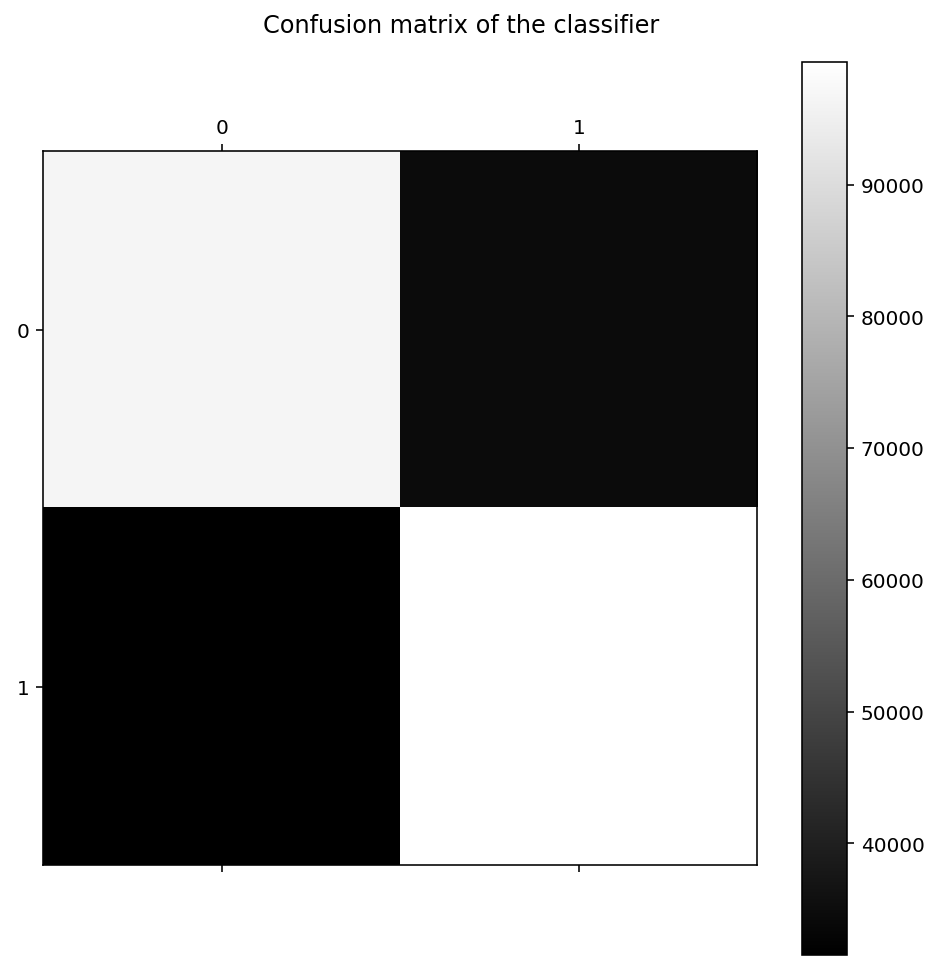

In [31]:
plt.figure(figsize=(8, 8), dpi=144)
plt.title('Confusion matrix of the classifier')
ax = plt.gca()                                  
ax.spines['right'].set_color('none')            
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.matshow(cm, fignum=1, cmap='gray')
plt.colorbar();